# Spectral analysis Sentinel 2 image Nazare
##### November 2024, (Golden)

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import xarray as xr
import cmath


In [2]:
ds_nazare = xr.open_dataset('../data/s2_nazare.nc')
ds_nazare

<xarray.Dataset>
Dimensions:                        (bands: 3, x_indices: 10980, y_indices: 10980)
Coordinates:
  * bands                          (bands) object 'B02_10m' 'B04_10m' 'B08_10m'
  * x_indices                      (x_indices) int64 0 1 2 ... 10977 10978 10979
  * y_indices                      (y_indices) int64 0 1 2 ... 10977 10978 10979
Data variables:
    __xarray_dataarray_variable__  (bands, x_indices, y_indices) uint16 ...

In [3]:
# The edges of the images are:

LONMAX = 351.11392563015653
LATMAX = 39.750212021802014
LONMIN = 349.8323752724691
LATMIN = 38.755193805393134

In [4]:

ds_nazare['brightness'] = ds_nazare['__xarray_dataarray_variable__']

ds_nazare = ds_nazare.drop(['__xarray_dataarray_variable__'])

In [5]:
ds_nazare = ds_nazare.sel(bands = 'B02_10m')

In [6]:
sub_indices_x = np.array(np.arange(8000, 10000, 1), dtype = int)
sub_indices_y = np.array(np.arange(0, 2000, 1), dtype = int)

In [7]:
sub_ds_nazare = ds_nazare.sel(x_indices = sub_indices_y, y_indices = sub_indices_x)

In [8]:
sub_ds_nazare

<xarray.Dataset>
Dimensions:     (x_indices: 2000, y_indices: 2000)
Coordinates:
    bands       <U7 'B02_10m'
  * x_indices   (x_indices) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * y_indices   (y_indices) int64 8000 8001 8002 8003 ... 9996 9997 9998 9999
Data variables:
    brightness  (x_indices, y_indices) uint16 ...

In [9]:
# sub_sub_indices_x = np.array(np.arange(8500, 8750, 1), dtype = int)
# sub_sub_indices_y = np.array(np.arange(1250, 1500, 1), dtype = int)

sub_sub_indices_x = np.array(np.arange(8500, 8800, 1), dtype = int)
sub_sub_indices_y = np.array(np.arange(0, 300, 1), dtype = int)


lonmin = sub_sub_indices_x.min()  # Minimum longitude (west)
lonmax = sub_sub_indices_x.max()  # Maximum longitude (east)
latmin = sub_sub_indices_y.min()   # Minimum latitude (south)
latmax = sub_sub_indices_y.max()   # Maximum latitude (north)


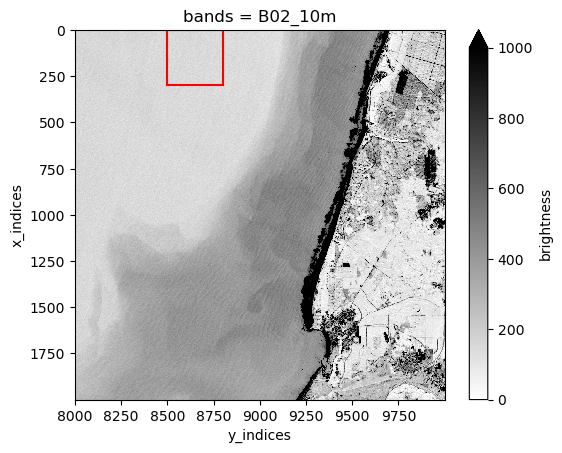

In [10]:
fig, ax = plt.subplots()
sub_ds_nazare.brightness[::1, ::1].plot(ax = ax, vmin = 0, vmax = 1000, cmap = 'binary')
# Draw the bounding box using the min/max values of lon and lat

plt.plot([lonmin, lonmax], [latmin, latmin], color='r', label="Bounding Box")  # Bottom edge
plt.plot([lonmin, lonmax], [latmax, latmax], color='r')  # Top edge
plt.plot([lonmin, lonmin], [latmin, latmax], color='r')  # Left edge
plt.plot([lonmax, lonmax], [latmin, latmax], color='r')  # Right edge

ax.invert_yaxis()
ax.set_aspect('equal', 'box')

In [11]:
sub_sub_ds_nazare = ds_nazare.sel(x_indices = sub_sub_indices_y, y_indices = sub_sub_indices_x)

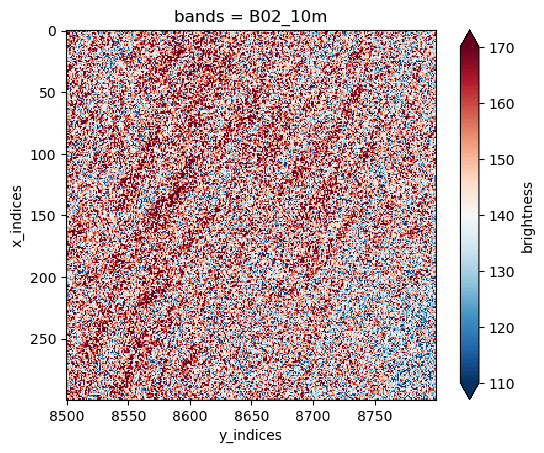

In [12]:
fig, ax = plt.subplots()
sub_sub_ds_nazare.brightness[::1, ::1].plot(ax = ax, vmin = 110, vmax = 170, cmap = 'RdBu_r')
ax.invert_yaxis()
ax.set_aspect('equal', 'box')


In [13]:
def two_dimensional_spectrum(field_2D, dx, dy):
    """
    Purpose:
    --------
    Perform the spectral analysis of the 2D MASS SSH with a pixel size of dx and dy
    Inputs:
    --------
    field_2D: The 2D MASS swath (dimensions ~ 2500 m| x 500 m)
    dx: pixel size in x
    dy: pixel size in y
    Outputs:
    --------
    phase_spec: The phase spectrum
    kx, ky the zonal and the meridional wavenumbers
    psd2D: The two-dimensional wave spectrum
    Z_shift: the intermediate wave spectrum
    dkx, dky: The wavenumber bins
    wc2xy: The 2D window correction 
    """
    
    Nx = np.size(field_2D, 0)
    Ny = np.size(field_2D, 1)
    
    #-----------------------------
    ###### hanning
    #-----------------------------
    #1D  windows

    hanningx = 0.5 * (1-np.cos(2*np.pi*np.transpose(np.linspace(0,Nx-1,Nx))/(Nx-1)))
    hanningy = np.ones((1,Ny))*0.5 * (1-np.cos(2*np.pi*np.linspace(0,Ny-1,Ny)/(Ny-1)))

    hanningxy = np.matlib.repmat(hanningx,Ny,1)*np.matlib.repmat(np.transpose(hanningy), 1, Nx)

    # window correction factors
    wc2x = 1/np.mean(hanningx**2)
    wc2y = 1/np.mean(hanningy**2)
    wc2xy  = wc2x * wc2y

#----------------------------
#spatial frequency axis
#----------------------------

    kx_max=(2*np.pi/dx)/2
    ky_max=(2*np.pi/dy)/2

    # step
    dkx=2*np.pi/(dx*(Nx//2)*2) #if odd-value data the max and min
    dky=2*np.pi/(dy*(Ny//2)*2)

    if np.mod(Nx,2)==0:
        #axes (for even-valued data, after fftshift...see example fft in MATLAB)
        kx=np.linspace(-kx_max, kx_max-dkx, Nx)
    else: #odd
        kx=np.linspace(-kx_max, kx_max, Nx)

    if np.mod(Ny,2)==0:
        #axes (for even-valued data, after fftshift...see example fft in MATLAB)
        ky=np.linspace(-ky_max, ky_max-dky, Ny)
    else: #odd
        ky=np.linspace(-ky_max, ky_max, Ny)

    dataW=np.zeros((np.shape(field_2D)))
    
    dkx = kx[3] - kx[2]
    dky = ky[3] - ky[2]
    
    #windowing
    new_data= field_2D - np.mean(field_2D[:])
    dataW = new_data*hanningxy.T
        
    #--------------------------
    # Spectral analysis
    #--------------------------

    #Z_fft = np.fft.fft2(dataW, s=None)
    #Z_shift = np.fft.fftshift(Z_fft)/(Nx*Ny)
    Z_shift = np.fft.fftshift(np.fft.fft2(dataW))/ (Nx*Ny)
        
    # Calculate a 2D power spectrum
    psd2D_0 = np.abs(Z_shift)**2/(dkx*dky)
    phase_spec=np.arctan2(np.imag(Z_shift), np.real(Z_shift))

    psd2D = psd2D_0*wc2xy
    Ekxky = xr.DataArray(psd2D, [('kx', kx),  ('ky', ky)])

    ds = xr.Dataset({'kx': ('kx', kx),
                    'ky': ('ky', ky),
                    })
                    
    ds['Ekxky'] = Ekxky
    ds = ds.set_coords(('kx', 'ky'))

    ds['Ekxky'].attrs['units'] = 'm^2/(rad/m)'

    ds['kx'].attrs['units'] = 'rad/m'
    ds['ky'].attrs['units'] = 'rad/m'

    return ds

def E_kxky_to_Ekth(E_kxky, kx, ky, number_of_dirs = 24):
    """
    Purpose: Interpolate the (kx, ky) spectrum onto directional-wavenumber spectrum
    inputs:
    E_kxky: the 2D wavenumber spectrum
    kx: the horizontal wavenumber (1D)
    ky: the vertical wavenumber (1D)
    
    outputs:
    dirspec: wavenumber-direction spectrum
    dd_new, kk_new: 2D dir-wavenumber axes
    """
    nk = np.size(kx)
    dkx = kx[1]-kx[0]
    k_new = np.linspace(0, np.amax(kx), nk)
    # Number of directions that you want on the polar grid
    nd = number_of_dirs
    dd = 2*np.pi/nd
    # Direction axis on the polar grid ranging from -pi to pi with dd increments
    d_new = np.arange(-np.pi, np.pi, dd)
    # Polar grid to interpolate onto
    # d_new = d_new0[number_of_dirs//2:]

    kk_new, dd_new = np.meshgrid(k_new, d_new)

    dirspec = xr.DataArray(np.zeros(dd_new.shape) * np.nan, [('theta', d_new),  ('K', k_new)])
    
    # Be sure working with a good xarray format
    Ekxky = xr.DataArray(E_kxky.T, dims=['ky', 'kx'], coords={'ky':ky, 'kx':kx})

    for i in range(nd):
        di = dd_new[i][0]
        ki = k_new
        kx_int = xr.DataArray(ki*np.cos(di), dims='K')
        ky_int = xr.DataArray(ki*np.sin(di), dims='K')
        dirspec[i, :] = Ekxky.interp(ky=ky_int, kx=kx_int)

    #here we're multiplying by the jacobian of the transformation from cartesian to polar
    dirspec = dirspec * kk_new 
    
    return dirspec, dd_new, kk_new

In [14]:
ds

NameError: name 'ds' is not defined

In [15]:
dx = 10
dy = dx
ds = two_dimensional_spectrum(sub_sub_ds_nazare.brightness[::1, ::-1].values, dx, dy)
dirspec, dd_new, kk_new = E_kxky_to_Ekth(ds.Ekxky, ds.kx.values, ds.ky.values, number_of_dirs = 48)

In [29]:
dirSpec = xr.DataArray(data=dirspec, dims=['directions', 'wavenumber'],
            coords=dict(directions=dd_new[:,0], wavenumber=kk_new[0,:]))

    # #print(dirSpec)
spec_2d = xr.Dataset()
spec_2d['wave_directional_spectrum'] = dirSpec
spec_2d.directions.attrs['units'] = 'rad'
spec_2d.directions.attrs['long_name'] = 'directions'
spec_2d.wavenumber.attrs['units'] = 'rad/m'
spec_2d.wavenumber.attrs['long_name'] = 'wavenumber'
spec_2d.attrs['creator'] = 'Gwendal Marechal'
spec_2d.attrs['data_created'] = time.ctime()
# spec_2d.to_netcdf('/Users/gwen29360/Desktop/ray_tracing/data/spec_s2.nc', format="NETCDF3_CLASSIC")

/Users/gwen29360/opt/anaconda3/envs/smode_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


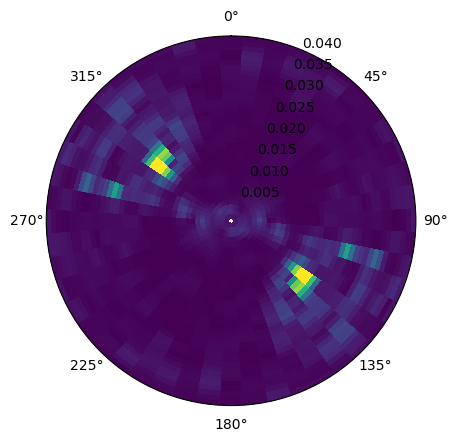

In [30]:
fig, ax = plt.subplots(subplot_kw = {'projection':'polar'})
ax.pcolor(dd_new, kk_new, dirspec, vmin = 0, vmax = 2000)
ax.set_ylim([0, .04])
ax.set_theta_offset(np.pi/2) # shift the 0 to the nroth
ax.set_theta_direction(-1) # swap the direction (clockwise)



In [142]:
L = 520
k = 2*np.pi/L

In [143]:
f = (9.81 * k)**(1/2)/(2*np.pi)
T = 1/(f)
T

18.249757681307464

In [1]:
kk_new[0,14]

NameError: name 'kk_new' is not defined

In [121]:
print(f'The indident wavelength is {2*np.pi/kk_new[0,14]} m; Tp = {T} sec')


The indident wavelength is 430.0095877277085 m; Tp = 16.59565890069831 sec


In [27]:
mini_sub_indices_y = np.array(np.arange(8700, 8800, 1), dtype = int)
mini_sub_indices_x = np.array(np.arange(0, 100, 1), dtype = int)

In [92]:
ds_nazare = xr.open_dataset('../data/s2_nazare.nc')

ds_nazare_1 = ds_nazare.sel(bands = 'B02_10m')
ds_nazare_2 = ds_nazare.sel(bands = 'B08_10m')


ds_nazare_1['brightness'] = ds_nazare_1['__xarray_dataarray_variable__']
ds_nazare_1 = ds_nazare_1.drop(['__xarray_dataarray_variable__'])

ds_nazare_2['brightness'] = ds_nazare_2['__xarray_dataarray_variable__']
ds_nazare_2 = ds_nazare_2.drop(['__xarray_dataarray_variable__'])
sub_sub_ds_nazare_1 = ds_nazare_1.sel(x_indices = mini_sub_indices_y, y_indices = mini_sub_indices_x)
sub_sub_ds_nazare_2 = ds_nazare_2.sel(x_indices = mini_sub_indices_y, y_indices = mini_sub_indices_x)

# ds_1 = two_dimensional_spectrum(sub_sub_ds_nazare_1.brightness[::1, ::-1].values, dx, dy)
# ds_2 = two_dimensional_spectrum(sub_sub_ds_nazare_2.brightness[::1, ::-1].values, dx, dy)
Nx = len(mini_sub_indices_y)
Ny = Nx
hanningx = 0.5 * (1-np.cos(2*np.pi*np.transpose(np.linspace(0,Nx-1,Nx))/(Nx-1)))
hanningy = np.ones((1,Ny))*0.5 * (1-np.cos(2*np.pi*np.linspace(0,Ny-1,Ny)/(Ny-1)))

hanningxy = np.matlib.repmat(hanningx, Ny, 1)*np.matlib.repmat(np.transpose(hanningy), 1, Nx)

z_shift1 = np.fft.fftshift(np.fft.fft2(sub_sub_ds_nazare_1.brightness.values*hanningxy, s = None))/(Nx*Ny)
z_shift2 = np.fft.fftshift(np.fft.fft2(sub_sub_ds_nazare_2.brightness.values*hanningxy, s = None))/(Nx*Ny)

phase_spec_1 = np.arctan2(np.imag(z_shift1), np.real(z_shift1))
phase_spec_2 = np.arctan2(np.imag(z_shift2), np.real(z_shift2))

In [93]:
ds_mini = two_dimensional_spectrum(sub_sub_ds_nazare_1.brightness[::1, ::-1].values, dx, dy)


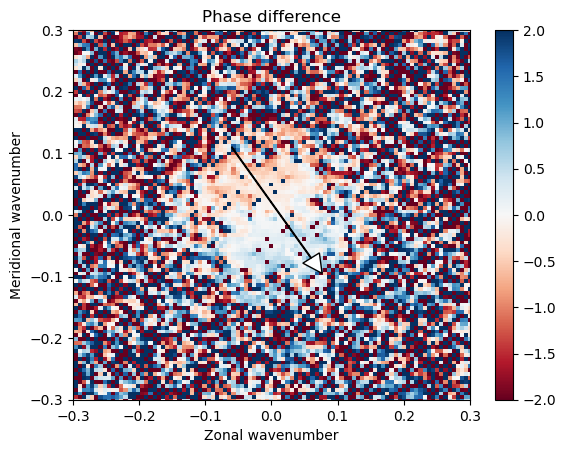

In [116]:
plt.pcolor(ds_mini.kx, ds_mini.ky, (phase_spec_2-phase_spec_1), vmin = -2, vmax = 2, cmap = 'RdBu')
plt.colorbar()
plt.xlim([-0.3, .3])
plt.ylim([-0.3, .3])
plt.xlabel('Zonal wavenumber')
plt.ylabel('Meridional wavenumber')
plt.title('Phase difference')

# --- Arrow
x_start, y_start = -.06, .11  # Starting point
x_end, y_end = .06, -.07     # Ending point

# Calculate the displacement
dx = x_end - x_start
dy = y_end - y_start


# Draw the arrow: (x_start, y_start) to (x_end, y_end)
plt.arrow(x_start, y_start, dx, dy, head_width=0.03, head_length=0.03, fc='w', ec='k')
